# Google Play Store Rating Prediction

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv('../Downloads/Google Play Store Apps Dataset/googleplaystore.csv')

In [3]:
#Function below consumes a data frame and returns percentage/number of missing values for each feature(column).

def missing_values(test):
    total = test.isnull().sum().sort_values(ascending=False)
    percent_1 = test.isnull().sum() / test.isnull().count() * 100
    percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
    missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
    
    return missing_data.head((missing_data['Total'] >= 0).sum())

In [4]:
missing_values(df)

,Total,%
Rating,1474,13.6
Current Ver,8,0.1
Android Ver,3,0.0
Type,1,0.0
Content Rating,1,0.0
App,0,0.0
Category,0,0.0
Reviews,0,0.0
Size,0,0.0
Installs,0,0.0


In [5]:
df.dropna(inplace = True)

Display the amount of missing values per column and what percentage of the column contains missing values

In [6]:
missing_values(df)

,Total,%
App,0,0.0
Category,0,0.0
Rating,0,0.0
Reviews,0,0.0
Size,0,0.0
Installs,0,0.0
Type,0,0.0
Price,0,0.0
Content Rating,0,0.0
Genres,0,0.0


In [7]:
df.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver'],
      dtype='object')


We remove features that aren't useful for our modeling (Last Updated, Current Ver, and Android Ver).

In [8]:
not_useful = ['Last Updated', 'Current Ver', 'Android Ver']
df = df.drop(not_useful, axis = 1)
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9360 non-null   object 
 1   Category        9360 non-null   object 
 2   Rating          9360 non-null   float64
 3   Reviews         9360 non-null   object 
 4   Size            9360 non-null   object 
 5   Installs        9360 non-null   object 
 6   Type            9360 non-null   object 
 7   Price           9360 non-null   object 
 8   Content Rating  9360 non-null   object 
 9   Genres          9360 non-null   object 
dtypes: float64(1), object(9)
memory usage: 804.4+ KB


We first convert Reviews to numeric form.

In [10]:
df = df.astype({'Reviews': 'int32'})

Now, we convert Installs to numeric, removing the '+' at the end of each value.

In [11]:
df['Installs'].unique()

array(['10,000+', '500,000+', '5,000,000+', '50,000,000+', '100,000+',
       '50,000+', '1,000,000+', '10,000,000+', '5,000+', '100,000,000+',
       '1,000,000,000+', '1,000+', '500,000,000+', '100+', '500+', '10+',
       '5+', '50+', '1+'], dtype=object)

In [12]:
# Regex = regular expression. \ character mean includes
df['Installs'] = df['Installs'].replace('[\,]', '', regex = True).replace('[\+]', '', regex = True).astype(int)

In [13]:
df['Installs'].unique()

array([     10000,     500000,    5000000,   50000000,     100000,
            50000,    1000000,   10000000,       5000,  100000000,
       1000000000,       1000,  500000000,        100,        500,
               10,          5,         50,          1])

We will be starting by using LabelEncoding on "Type" column. There are only 2 categories and no Nan values.

In [16]:
# Change price column to free = 0 and paid = 1
# creating instance of labelencoder
paid_types = df["Type"].unique()
labelencoder = LabelEncoder()
df['Type'] = labelencoder.fit_transform(df['Type'])

Now, we deal with the "Price" column. Note that here, the data is already mostly numerical, so we will only remove the dollar sign

In [17]:

before = df["Price"].nunique()

df["Price"] = df["Price"].replace('[\$,]', '', regex=True).astype(float)

after = df["Price"].nunique()

f"Unique values before: {before}, unique values after: {after}"

'Unique values before: 73, unique values after: 73'

In [18]:
#Then, "Content Rating". First, check all categories in this column.

df["Content Rating"].unique()

array(['Everyone', 'Teen', 'Everyone 10+', 'Mature 17+',
       'Adults only 18+', 'Unrated'], dtype=object)

First, as we can't assign a specific order to "Unrated", we will see how many rows have that value. If there are very few, we will use SimpleImputer to change change the value to the most common one

In [19]:
df[(df["Content Rating"] == "Unrated")]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres
8266,DC Universe Online Map,TOOLS,4.1,1186,6.4M,50000,0,0.0,Unrated,Tools


In [20]:
imp_const = SimpleImputer(missing_values="Unrated", strategy = "most_frequent")
imp_const.fit(pd.DataFrame(df["Content Rating"]))
df["Content Rating"] = imp_const.transform(pd.DataFrame(df["Content Rating"]))

In [21]:
df["Content Rating"].unique()

array(['Everyone', 'Teen', 'Everyone 10+', 'Mature 17+',
       'Adults only 18+'], dtype=object)

As the values in the "Content Rating" column can be ordered, we will be assigning a numerical value to each category. however, we will not be using LabelEncoder as is encodes in alphabetical order. Instead, we will create the an array of values we would like to replace and an array that we will replace with. Then, we iterate through both sets and replace on by one.

In [22]:
unique_cr = np.array(['Everyone', 'Everyone 10+', 'Teen', 'Mature 17+', 'Adults only 18+'])
n = np.array([0, 10, 13, 17, 18])

for i,j in zip(unique_cr, n):
    df["Content Rating"] = df["Content Rating"].replace([i,], j)

unq = df["Content Rating"].unique()
f"Unique values in converted \"Content Rating\": {unq}"

'Unique values in converted "Content Rating": [ 0 13 10 17 18]'

In [23]:
#Then, we work with "Size".
df["Size"].unique()[1:30]

array(['14M', '8.7M', '25M', '2.8M', '5.6M', '29M', '33M', '3.1M', '28M',
       '12M', '20M', '21M', '37M', '5.5M', '17M', '39M', '31M', '4.2M',
       '23M', '6.0M', '6.1M', '4.6M', '9.2M', '5.2M', '11M', '24M',
       'Varies with device', '9.4M', '15M'], dtype=object)

In [24]:
#We convert all the data in Size to MB or Nan.


def clean_size(size):
    if size[-1:] == "M":
        clean_size = float(size[:-1])
    elif size[-1:] == "k":
        clean_size = float(size[:-1]) / 1000
    else:
        clean_size = None
    return clean_size

df["Size"] = df["Size"].map(clean_size)

df["Size"].unique()[0:30]

array([19. , 14. ,  8.7, 25. ,  2.8,  5.6, 29. , 33. ,  3.1, 28. , 12. ,
       20. , 21. , 37. ,  5.5, 17. , 39. , 31. ,  4.2, 23. ,  6. ,  6.1,
        4.6,  9.2,  5.2, 11. , 24. ,  nan,  9.4, 15. ])


Now, we replace Nan values with mean and we add an extra column that will have 1 if the the original value in "Size" was "Varies with device" and 0 if it was an assigned value

In [25]:
#df["Size: Varies with device"] = (pd.get_dummies(df["Size"]))["nan"] <--- Gives error
imp_size = SimpleImputer(missing_values= np.nan ,strategy = "mean")
imp_size.fit(pd.DataFrame(df["Size"]))
df["Size"] = (imp_size.transform(pd.DataFrame(df["Size"])))
df["Size"].unique()[0:30]

array([19.        , 14.        ,  8.7       , 25.        ,  2.8       ,
        5.6       , 29.        , 33.        ,  3.1       , 28.        ,
       12.        , 20.        , 21.        , 37.        ,  5.5       ,
       17.        , 39.        , 31.        ,  4.2       , 23.        ,
        6.        ,  6.1       ,  4.6       ,  9.2       ,  5.2       ,
       11.        , 24.        , 22.97045611,  9.4       , 15.        ])

In [26]:
df.dtypes

App                object
Category           object
Rating            float64
Reviews             int32
Size              float64
Installs            int32
Type                int32
Price             float64
Content Rating      int64
Genres             object
dtype: object

Now, we will work with Category. As there are 33 categories, using onehot encoder would create a lot of extra columns. Hence, we will use labelencoder. As the data not ordered naurally, we will assign the highest value to the most common category and lowest to the least common

In [27]:
df["Category"].unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION'],
      dtype=object)

In [28]:
df[(df["Category"] == "FAMILY")]["Category"].count()

1746

In [29]:
n = df["Category"].unique()
c = []
for i in n:
    c.append([df[(df["Category"] == i)]["Category"].count(), i])
c.sort()

r = range(33)

for i,j in zip(c, r):
    df["Category"] = (df["Category"].replace(i[1], j, regex=True))

df["Category"] = df["Category"].astype("int")
c

[[42, 'BEAUTY'],
 [45, 'EVENTS'],
 [50, 'PARENTING'],
 [58, 'COMICS'],
 [61, 'ART_AND_DESIGN'],
 [64, 'LIBRARIES_AND_DEMO'],
 [73, 'AUTO_AND_VEHICLES'],
 [75, 'WEATHER'],
 [76, 'HOUSE_AND_HOME'],
 [109, 'FOOD_AND_DRINK'],
 [124, 'MAPS_AND_NAVIGATION'],
 [149, 'ENTERTAINMENT'],
 [155, 'EDUCATION'],
 [160, 'VIDEO_PLAYERS'],
 [178, 'BOOKS_AND_REFERENCE'],
 [195, 'DATING'],
 [226, 'TRAVEL_AND_LOCAL'],
 [233, 'NEWS_AND_MAGAZINES'],
 [238, 'SHOPPING'],
 [259, 'SOCIAL'],
 [297, 'HEALTH_AND_FITNESS'],
 [303, 'BUSINESS'],
 [312, 'PERSONALIZATION'],
 [314, 'LIFESTYLE'],
 [317, 'PHOTOGRAPHY'],
 [319, 'SPORTS'],
 [323, 'FINANCE'],
 [328, 'COMMUNICATION'],
 [350, 'MEDICAL'],
 [351, 'PRODUCTIVITY'],
 [733, 'TOOLS'],
 [1097, 'GAME'],
 [1746, 'FAMILY']]

In [30]:
df["Genres"].unique()[0:30]

array(['Art & Design', 'Art & Design;Pretend Play',
       'Art & Design;Creativity', 'Auto & Vehicles', 'Beauty',
       'Books & Reference', 'Business', 'Comics', 'Comics;Creativity',
       'Communication', 'Dating', 'Education;Education', 'Education',
       'Education;Creativity', 'Education;Music & Video',
       'Education;Action & Adventure', 'Education;Pretend Play',
       'Education;Brain Games', 'Entertainment',
       'Entertainment;Music & Video', 'Entertainment;Brain Games',
       'Entertainment;Creativity', 'Events', 'Finance', 'Food & Drink',
       'Health & Fitness', 'House & Home', 'Libraries & Demo',
       'Lifestyle', 'Lifestyle;Pretend Play'], dtype=object)

In [31]:
df[["Genre1", "Genre2"]] = df["Genres"].str.split(";", expand = True)
df = df.drop(["Genres"], axis=1)

df["Genre2"].unique()

array([None, 'Pretend Play', 'Creativity', 'Education', 'Music & Video',
       'Action & Adventure', 'Brain Games'], dtype=object)


We see that many values in the Genres column are the same as in Category. Since we might get 2 highly correlated columns, we should only keep one of them. We will be keeping Category as the data there is better organised.

In [32]:
df = df.drop(["Genre1", "Genre2"], axis=1)

<AxesSubplot:xlabel='Content Rating', ylabel='Rating'>

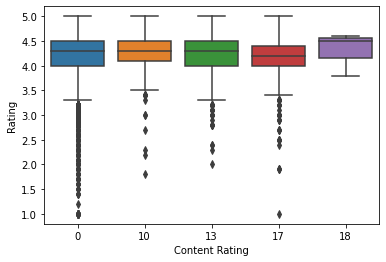

In [34]:
#Boxplot for Content Rating and Rating.
sns.boxplot(data=df, x="Content Rating", y="Rating")


We make a boxplot and see that category doesnt have that much of an effect on rating

<AxesSubplot:xlabel='Category', ylabel='Rating'>

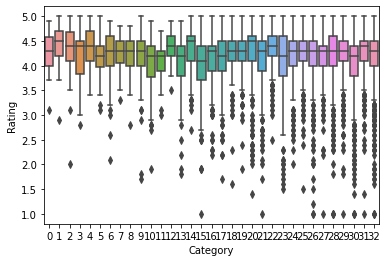

In [35]:
#Boxplot for Category and Rating.
sns.boxplot(data=df, x="Category", y="Rating")

We look at Size under 20mb because most apps in the data set are under 20mb and it looks nicer

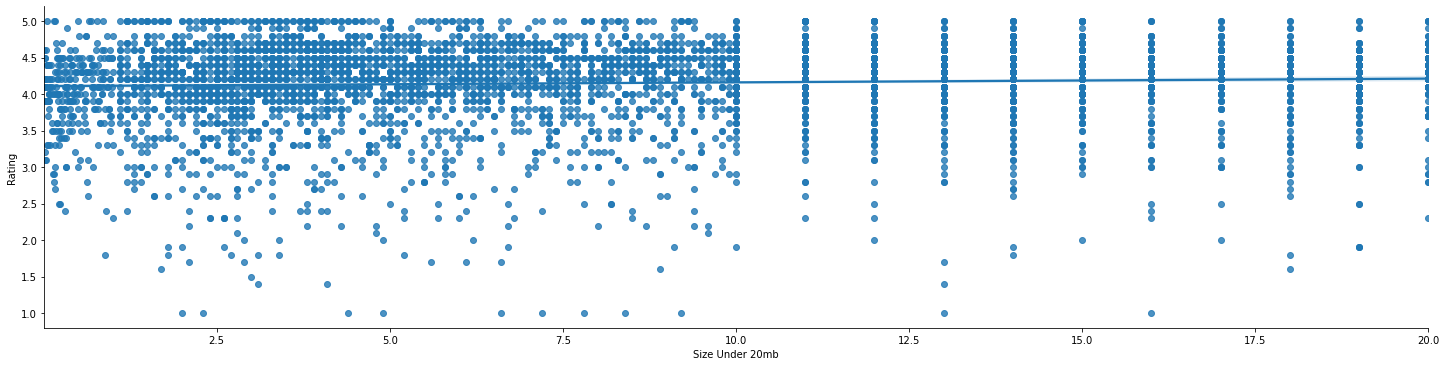

In [36]:
size_plot = pd.concat([df["Rating"], df["Size"][df["Size"] <= 20]], axis=1, keys=['Rating', 'Size Under 20mb'])
sns.lmplot(data=size_plot, x="Size Under 20mb", y="Rating", height=5, aspect=4)

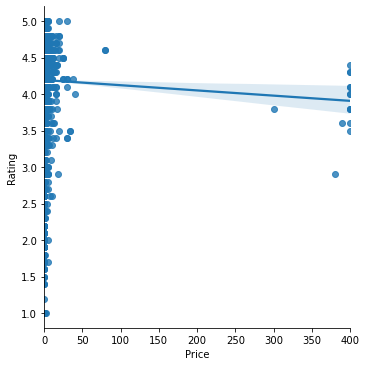

In [37]:
sns.lmplot(data=df, x="Price", y="Rating")

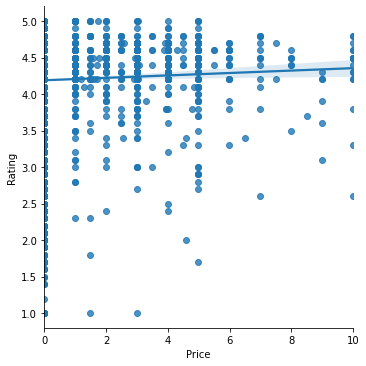

In [38]:
sns.lmplot(data=df[df["Price"] <= 10], x="Price", y="Rating")

## Model Setup


First, we define the data we will predict- 'Rating', and the data we will use to predit it- Category, Size, Type, Price, and Content Rating.

In [39]:
predict = "Rating"

X = np.array(df
             .drop(["App", "Price", predict], axis = 1))
X_without_rev_inst = np.array(df.drop(["App", "Price", "Reviews", "Installs", predict], axis = 1))
y = np.array(df[predict])

In [40]:
#We choose to use %90 of the data to train the models and %10 to test them.
# set up the train and test variables and choose to use %10 of the data for testing
x_train_without, x_test_without, y_train, y_test = sklearn.model_selection.train_test_split(X_without_rev_inst, y, test_size = 0.90)
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.90)

## Model Exploration

We will start by defining the function "models". This function is shown below. Note that we will be using train_test_split to randomly split the data and asses the performace of our model on random parts and aviod any accidental correlations or noise

In [41]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


# A function for mean absolute precentage error
def mean_absolute_percentage_error(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape


def models(X, y):
    X_train, X_val, Y_train, Y_val = train_test_split(X, 
                                                      y, 
                                                      random_state = 0)
    #Random Forest
    random_forest = RandomForestRegressor(n_estimators=100)
    random_forest.fit(X_train, Y_train)
    Y_pred = random_forest.predict(X_val)
    acc_random_forest = mean_absolute_percentage_error(Y_val, Y_pred)
    
    #Regression
    regr = linear_model.LinearRegression()

    regr.fit(X_train, Y_train)

    Y_pred = regr.predict(X_val)
    acc_linear_reg = mean_absolute_percentage_error(Y_val, Y_pred)
    
    return f"Random Forest Error: {acc_random_forest}%, Linear Regression Error: {acc_linear_reg}%"


The purpose of this function is to obtain the mean value error for each included model. We can then use it to understand the accuracy of each model

In [42]:
models(pd.DataFrame(X),y)

'Random Forest Error: 8.760474153871352%, Linear Regression Error: 10.10320381811356%'


Here, we have looked at the mean absolute percentage error for each model (linear and random forest). With both we can see that on average, the predictions are about 9% off with random forest and 10% off with linear regression. This formula is just another way of understanding which models would be most effective with the given data. In this case, we observe that Random forest's predictions are more precise on average. Also, it is important to note that as our data is continuous, it is more meningful to look at the average deviations from the real scores rather than counting 100% accurate predictions.


Now, we will have a deeper look into each of the models.

## Linear Regression Model

In [43]:
model_without_rev_installs = linear_model.LinearRegression()
model = linear_model.LinearRegression()

model_without_rev_installs.fit(x_train_without, y_train)
model.fit(x_train, y_train)

result_without = model_without_rev_installs.predict(x_test_without)
result = model.predict(x_test)

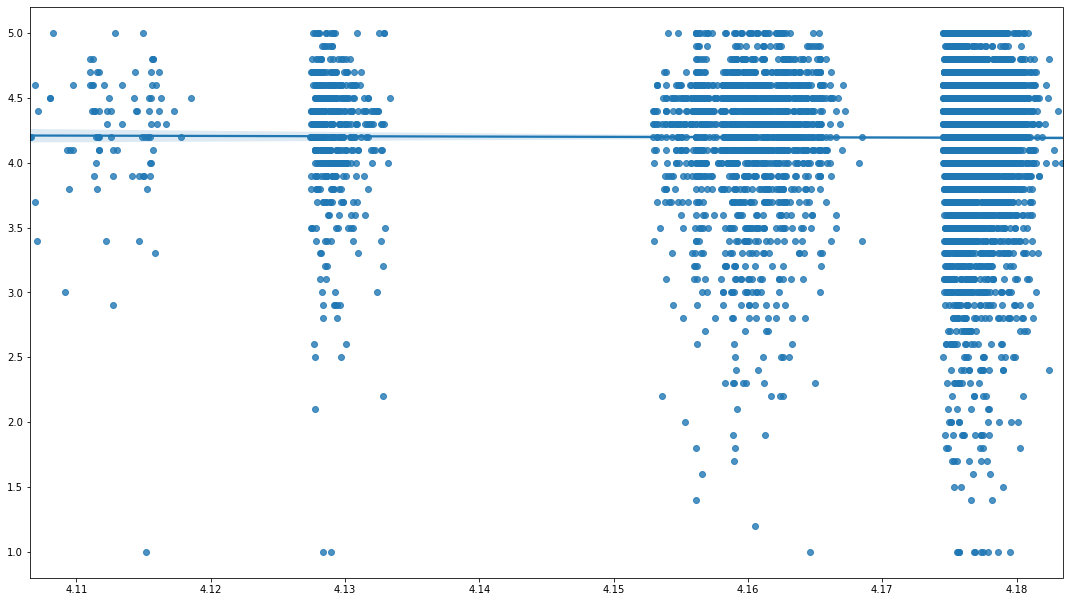

In [44]:
plot = sns.regplot(x=result_without, y=y_test)
plot.figure.set_size_inches(18.5, 10.5)

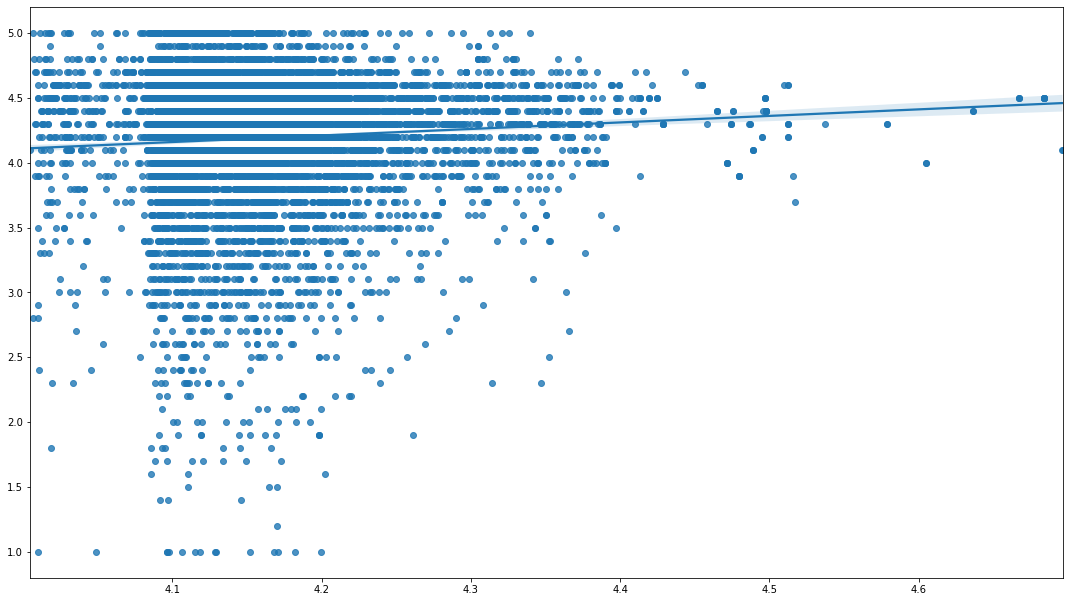

In [45]:

plot = sns.regplot(x=result, y=y_test)
plot.figure.set_size_inches(18.5, 10.5)

In [46]:
error_without = mean_absolute_percentage_error(y_test, result_without)
error = mean_absolute_percentage_error(y_test, result)
f"Error when using reviews and installs: {error}, Error without using reviews and installs: {error_without}"

'Error when using reviews and installs: 10.229180554249599, Error without using reviews and installs: 10.27542094544844'

## Random Forest Regressor Model

In [47]:
model_without_rev_installs = RandomForestRegressor(n_estimators = 10, random_state = 1)
model = RandomForestRegressor(n_estimators = 10, random_state = 1)

model_without_rev_installs.fit(x_train_without, y_train)
model.fit(x_train, y_train)

result_without = model_without_rev_installs.predict(x_test_without)
result = model.predict(x_test)

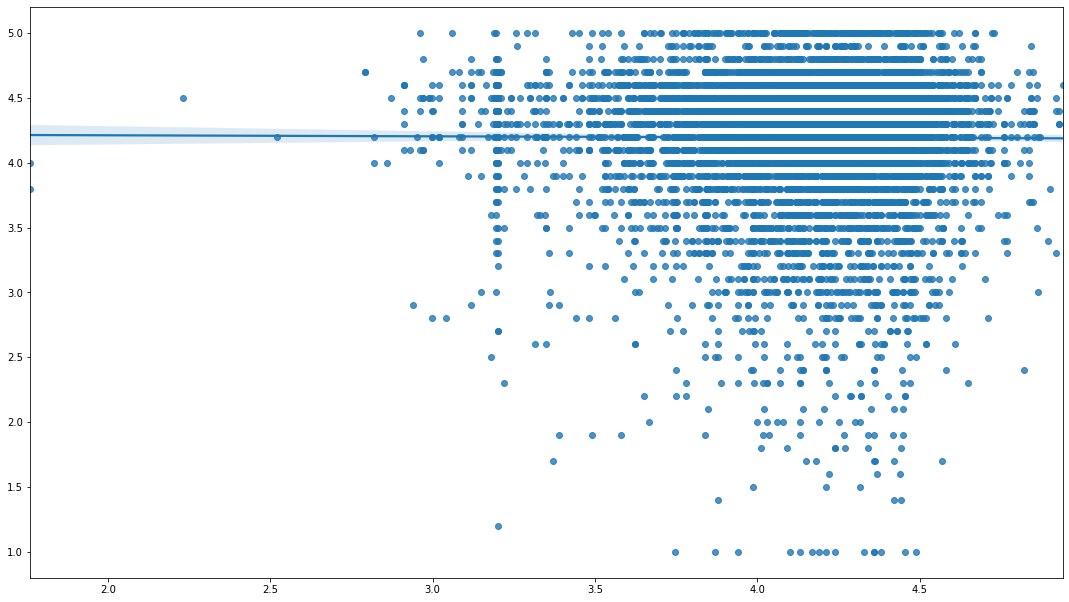

In [48]:
plot = sns.regplot(x=result_without, y=y_test)
plot.figure.set_size_inches(18.5, 10.5)

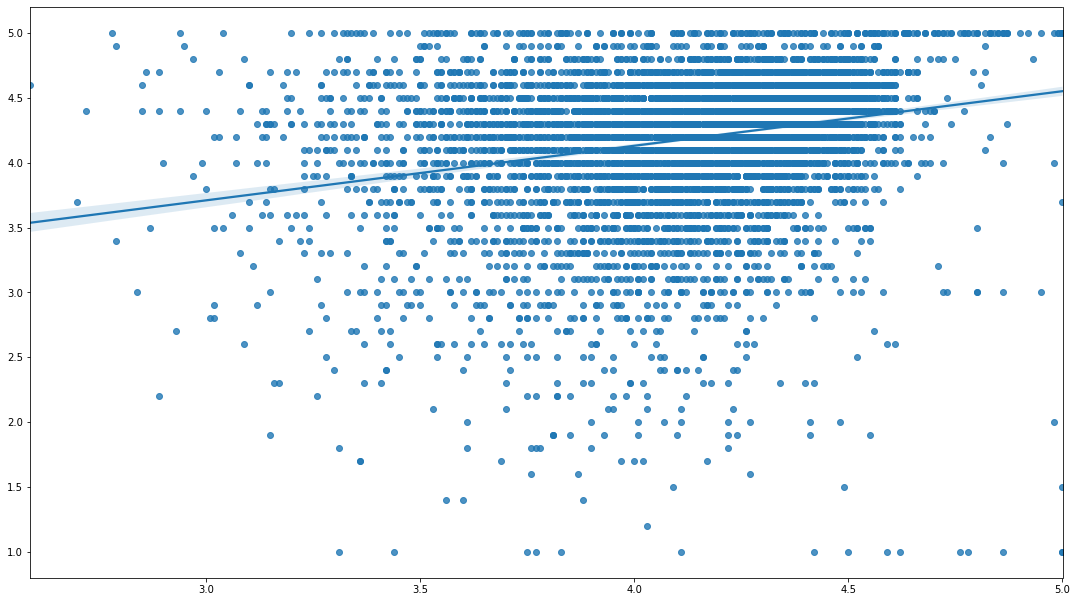

In [49]:

plot = sns.regplot(x=result, y=y_test)
plot.figure.set_size_inches(18.5, 10.5)

In [50]:
e_with = mean_absolute_percentage_error(y_test, result)
e_without = mean_absolute_percentage_error(y_test, result_without)
f"Error when using reviews and installs: {e_with}%, Error without using reviews and installs: {e_without}%"

'Error when using reviews and installs: 10.067935957240982%, Error without using reviews and installs: 12.116896751182567%'